# Yelp Rating
Based on yelp challenge dataset, we aim to predict a review's rating.

The loss function is RMSE. (Should probably use precision/recall)

Data I have:
```
1. business:          data about each business' attributes
2. test_queries:      predict how each of the values will turn out for that user and business
3. train reviews:     reviews by each user about some businesses
4. users:             data about how each user usually rates things
5. validate_queries:  a validation set of how each user rates a business
```

Perez says content filtering techniques may be viable due to DL:
    - "Predicting Yelp Star Reviews Based on Network Structure with Deep Learning" 
    - https://arxiv.org/abs/1712.04350
        - Uses a user model
        - a business model
        - an interaction model
Going to first try several different collaborative filtering techniques:
1. Memory-based

2. Model-based

- Neural networks: (can try autoencoder)
    - Rating matrix can be also compressed by a neural network. So called autoencoder is very similar to the matrix factorization. Deep autoencoders, with multiple hidden layers and nonlinearities are more powerful but harder to train. Neural net can be also used to preprocess item attributes so we can combine content based and collaborative approaches.

- Paper with "Deep Learning based Recommender System: A Survey and New Perspectives"
- UCI yelp: https://www.math.uci.edu/icamp/summer/research/student_research/recommender_systems_slides.pdf
    - How blending is done: https://www.quora.com/How-can-I-combine-recommender-system-outputs-user-item-matrix-via-an-ensemble
- Should split data along time dimension 

## Feature Engineering

### Imports

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import pandas as pd
import torch.nn as nn
import torch.autograd
import torch.nn.functional as F
import torch
import numpy as np
from fastai.learner import *
from fastai.column_data import *
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

torch.manual_seed(1)

# from rgao_dl.utils import *
# from rgao_dl.data import *
# from rgao_dl.train import *

In [4]:
df_business = pd.read_csv('business.csv')
train_reviews = pd.read_csv('train_reviews.csv')
df_users = pd.read_csv('users.csv')

test_queries = pd.read_csv('test_queries.csv')
val_queries = pd.read_csv('validate_queries.csv')

## EDA

### Enumerate all id's
Change id's to indicies
user_id based on df_user (assuming has all users in the test, train and val splits)
business_id based on df_business (assuming has all businesses)

change the interaction matrix, df_business, and df_users <br>
change train, val, and test data with the corresponding indicies

In [314]:
# Change train_reviews. Encode user_id and business_id to 0-len
u_unique = df_users['user_id'].unique()
user2idx = {orig_u: idx for idx, orig_u in enumerate(u_unique)}
trn_data['user_id'] = train_reviews['user_id'].apply(lambda x: user2idx[x])

df_business['average_stars'] = df_business['stars']
b_unique = df_business['business_id'].unique()
business2idx = {orig_b: idx for idx, orig_b in enumerate(b_unique)}
trn_data['business_id'] = train_reviews['business_id'].apply(lambda x: business2idx[x])

# same for df_users
user_data = df_users.drop(['name','yelping_since','elite','friends'],axis=1)
user_data['user_id'] = user_data['user_id'].apply(lambda x: user2idx[x])

# same for businesses
bus_data = df_business.drop(['address','attributes','hours','is_open','latitude', 'longitude','state'], axis=1)
bus_data['business_id'] = bus_data['business_id'].apply(lambda x: business2idx[x])

# Same for val
val_data = val_queries.drop(['stars','Unnamed: 0'],axis=1)
val_data['user_id'] = val_queries['user_id'].apply(lambda x: user2idx[x])
val_data['business_id'] = val_queries['business_id'].apply(lambda x: business2idx[x])

# Same for test
test_data = test_queries.copy()  # default is deep copy
test_data['user_id'] = test_queries['user_id'].apply(lambda x: user2idx[x])
test_data['business_id'] = test_queries['business_id'].apply(lambda x: business2idx[x])


### Train_review.csv 
- date is included so possibility of including embeddings for time following rossman challenge
- text is included so sentiment analysis is possible but probably not necessary since rating is included as well
- rating (stars) is included so we already have feedback
- categorical traits: 
    - cool, funny, useful
    - user_id and review_id. Review_id is useless since always unique
    
__ Overall, I've looked around for a lot of recommender systems and I can't seem to find anything that matches my needs. Most examples are just copies of each other using the embedding neural network =(. I'm going to use that just for train_reviews to see how i do. This will be my interaction model __
<br>
<br>

### Users.csv

In [13]:
df_users.head()

,average_stars,compliment_cool,compliment_cute,compliment_funny,compliment_hot,compliment_list,compliment_more,compliment_note,compliment_photos,compliment_plain,...,cool,elite,fans,friends,funny,name,review_count,useful,user_id,yelping_since
0,2.83,0,0,0,0,0,0,0,0,1,...,0,None,0,None,2,James,6,7,UxfpKHGO2dfQCdS9xLLJow,2012-04-25
1,3.00,0,0,0,0,0,0,0,0,0,...,0,None,0,None,0,Yvonne,4,0,Kr5NDQFPPB_01-5CDmSqVg,2015-11-30
2,3.09,0,0,0,0,0,0,0,0,0,...,0,None,1,None,0,Etobicoke,10,2,wfoeMtriLwZsdRzcxNTaFA,2012-11-13
3,4.00,0,0,0,0,0,0,0,0,0,...,0,None,0,None,0,Shirley,4,0,aXb0kCIsIbPEEUSGomrrmA,2014-09-10
4,4.00,0,0,0,0,0,0,0,0,0,...,0,None,0,None,0,Brian,1,0,sLrX2KGu3lc_JczAnsg0_Q,2015-03-22


#### Missing values

In [32]:
n = [df_users[c].isnull().sum() for c in df_users.columns]
n

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 15, 0, 0, 0, 0]

only missing 15 names for each of the users?

#### Distribution of review counts

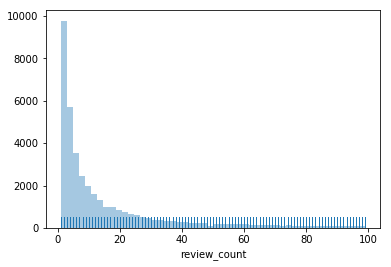

In [180]:
sns.distplot((df_users.review_count[(df_users.review_count > 0) & (df_users.review_count < 100)]), kde=False, rug=True)

Generally people aren't doing any reviews

### business.csv thoughts

#### Sparsity
lots of missing values in the attributes

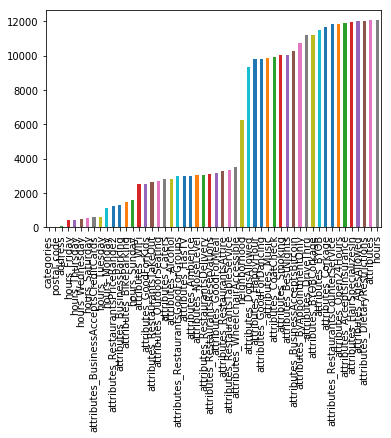

In [12]:
missing_bus = df_business.isnull().sum()
missing_bus = missing_bus[missing_bus > 0]
missing_bus.sort_values(inplace=True)
missing_bus.plot.bar()

In [36]:
s = df_business.review_count.unique()
s.sort()
s

array([ 100,  101,  102, ..., 6446, 7866, 7968], dtype=int64)

Seems I don't need to eliminate any small outliers for review count since the lowest is 100 reviews

# Modeling

## Baseline

Baseline estimate rating: $b_{u,i} = \mu + b_u + b_i $ 
(Using 1 if b_u or b_i is missing)
- $\mu$ the mean rating of all ratings in the system
- $b_u$ abs(average rating of user u and $\mu$)
- $b_i$ abs(average rating of business i and $\mu$)

In [186]:
b_u = {u: train_reviews[train_reviews.user_id == u].stars.mean() for u in val_queries.user_id.unique()}
b_u = pd.DataFrame.from_dict(b_u, orient='index', columns=['vals'])
b_u = b_u.vals.fillna(1)

In [187]:
# business_id
# b_b = []; b_dict = dict()
# for b in val_queries.business_id:
#     if b in b_dict:
#         b_b.append(b_dict[b])
#     else:
#         avg = val_queries[val_queries.business_id == b].stars.mean()
#         b_dict[b] = avg
#         b_b.append(avg)
# len(b_b)
        


b_unique = df_business.business_id.unique()
b_i = dict()
for b in val_queries.business_id.unique():
    if b in b_unique: 
        b_i[b] = df_business[df_business.business_id == b].iloc[0]['stars']
    else: 
        b_i[b] = 1

In [199]:
mu = train_reviews.stars.mean()
b_u_ = [b_u[u] for u in val_queries.user_id]
b_b_ = [b_i[i] for i in val_queries.business_id]

In [200]:
np_b = np.asarray(b_b_)
np_u = np.asarray(b_u_)
preds = (np_b - mu) + (np_u - mu) + mu

In [201]:
# RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt
y_predicted = preds
y_actual = val_queries.stars.values
rmse_error = sqrt(mean_squared_error(y_actual, y_predicted))
rmse_error 

2.1334241802488543

# Collaborative Filtering

## First Method: Only EmbeddingNet (Matrix factorization method)
- Drop everything except the business_id, user_id, and rating makes a typical rating matrix perfect for an embedding net

#### Drop columns

In [5]:
# drop tons of columns
trn_data = train_reviews.drop(['review_id', 'text', 'date', 'cool', 'funny', 'useful'], axis=1)
trn_data.head()

,business_id,stars,user_id
0,WPCgtEG-bJt0cZtnM-x7yw,4.0,VDh1vjzpNUJH6HfcjH8g7Q
1,LnnO7quTjjdTUkCshSJnkA,5.0,HnnjIuLrdhLTsRRVrrFIjA
2,sKrlmbrZWCyLIgiMihCPqw,5.0,HnnjIuLrdhLTsRRVrrFIjA
3,Lh5qnT2m2b4lvyYiMGMDkg,4.0,HnnjIuLrdhLTsRRVrrFIjA
4,54LYVM1gCGQ2UVFK9QhgTw,5.0,HnnjIuLrdhLTsRRVrrFIjA


there is time included. Can't use any naive assumption that the reviews IID since each review will most likely have some sort of influence on the one before it. 

#### Missing Values

No missing values?  a godsend

In [29]:
miss_trn = trn_data.isnull().sum()
miss_trn

business_id    0
user_id        0
dtype: int64

### Model

In [7]:
class EmbeddingNet(nn.Module):
    def __init__(self, n_users, n_movies, max_rating, min_rating, nh=10, p1=0.05, p2=0.5, n_factors=50):
        super().__init__()
        self.max_rating = max_rating
        self.min_rating = min_rating
        (self.u, self.m) = [self.get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors)]]
        self.lin1 = nn.Linear(n_factors * 2, nh)   # linear layer already includes a bias
        self.lin2 = nn.Linear(nh, 1)
        self.drop1 = nn.Dropout(p1)
        self.drop2 = nn.Dropout(p2)

    def get_emb(self, ni, nf):
        e = nn.Embedding(ni, nf)
        e.weight.data.uniform_(0.0, 0.01)
        return e

    def forward(self, cats, conts):
        users, movies = cats[:, 0], cats[:, 1]
        x = self.drop1(torch.cat([self.u(users), self.m(movies)], dim=1))
        x = self.drop2(F.relu(self.lin1(x)))
        # rounding this output gave worse results
        return torch.sigmoid(self.lin2(x)) * (self.max_rating - self.min_rating + 1) + min_rating - 0.5

### Stuff that Works

In [8]:
class ModelData():
    '''Encapsulates all Dataloaders'''
    def __init__(self, trn_dl, val_dl, test_dl=None):   
        self.trn_dl, self.val_dl, self.test_dl = trn_dl, val_dl, test_dl

In [9]:
# __getitem__ makes it an iterable. for loops take iteratorse which have a __next__ method
class CustomDataset(Dataset):
    def __init__(self, df, cat_flds, y=None, is_reg=True):
        '''Separate into x,y data'''
        cats = df[cat_flds]
        conts = df.drop(cat_flds, axis=1)
        
        # items iterates over columnname, Series pairs
        cat_cols = [c.values for n, c in cats.items()] # each n is moveId or userId, each c is all the Series data
        cont_cols = [c.values for n, c in conts.items()]
        
        n = len(cat_cols[0]) if cat_cols else len(cont_cols[0])
        # its really important that this is int64 for some reason       ######~TODO: Find out why~######
        # Form a list of lists. in the inner list is each pair (user, movie). self.cats is nparray
        self.cats = np.stack(cat_cols, axis=1).astype(np.int64) if cat_cols else np.zeros((n,1))
        self.conts = np.stack(cont_cols,axis=1).astype(np.float32) if cont_cols else np.zeros((n,1))
        self.y     = np.zeros((n,1))                       if y is None else y
        
        if is_reg:
            self.y =  self.y[:,np.newaxis]
        self.is_reg = is_reg
        
    def __getitem__(self, idx):
        '''Get an item from x, y data'''
        return self.cats[idx], self.conts[idx], self.y[idx]
    
    def __len__(self):
        '''Return length of dataset'''
        return len(self.y)

#### Stepper

In [10]:
class Stepper():
    def __init__(self, m, opt, crit):
        self.m,self.opt,self.crit = m,opt,crit
        self.reset(True)
        
    def reset(self, train=True):
        if train:
            layers = self.m.modules()
            if isinstance(self.m, nn.Module): self.m.train()
            for l in layers: l.train()
        else:
            #val
            self.m.eval()

    def step(self, xs, y, epoch):
        xtra = []
        output = self.m(*xs)
        self.opt.zero_grad()
        loss = raw_loss = self.crit(output, y)
        # for RMSE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        loss = torch.sqrt(loss); raw_loss = torch.sqrt(raw_loss)
        loss.backward()
        if 'wd' in self.opt.param_groups[0] and self.opt.param_groups[0]['wd'] != 0: 
            #Weight decay out of the loss. After the gradient computation but before the step.
            for group in self.opt.param_groups:
                lr, wd = group['lr'], group['wd']
                for p in group['params']:
                    if p.grad is not None: p.data = p.data.add(-wd * lr, p.data)
        self.opt.step()
        return torch_item(raw_loss.data)
    
    def evaluate(self, xs, y):
        preds = self.m(*xs)
        if isinstance(preds,tuple): preds=preds[0]
        return preds, self.crit(preds, y)

In [11]:
def split_by_idx(idxs, *a):
        """
        Split each array passed as *a, to a pair of arrays like this (elements selected by idxs,  the remaining elements)
        This can be used to split multiple arrays containing training data to validation and training set.
        :param idxs [int]: list of indexes selected
        :param a list: list of np.array, each array should have same amount of elements in the first dimension
        :return: list of tuples, each containing a split of corresponding array from *a.
                First element of each tuple is an array composed from elements selected by idxs,
                second element is an array of remaining elements.
        """
        mask = np.zeros(len(a[0]),dtype=bool)
        mask[np.array(idxs)] = True
        return [(o[mask],o[~mask]) for o in a]

# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

IS_TORCH_04 = LooseVersion(torch.__version__) >= LooseVersion('0.4')
def create_variable(x, volatile, requires_grad=False):
    if type (x) != Variable:
        if IS_TORCH_04: x = Variable(T(x), requires_grad=requires_grad)
        else:           x = Variable(T(x), requires_grad=requires_grad, volatile=volatile)
    return x

def is_listy(x): return isinstance(x, (list,tuple))

def map_over(x, f): return [f(o) for o in x] if is_listy(x) else f(x)

def V_(x, requires_grad=False, volatile=False):
    '''equivalent to create_variable, which creates a pytorch tensor'''
    return create_variable(x, volatile=volatile, requires_grad=requires_grad)

def V(x, requires_grad=False, volatile=False):
    '''creates a single or a list of pytorch tensors, depending on input x. '''
    return map_over(x, lambda o: V_(o, requires_grad, volatile))  

def T(a, half=False, cuda=True):
    """
    Convert numpy array into a pytorch tensor. 
    if Cuda is available and USE_GPU=ture, store resulting tensor in GPU.
    """
    if not torch.is_tensor(a):
        a = np.array(np.ascontiguousarray(a))
        if a.dtype in (np.int8, np.int16, np.int32, np.int64):
            a = torch.LongTensor(a.astype(np.int64))
        elif a.dtype in (np.float32, np.float64):
            a = torch.cuda.HalfTensor(a) if half else torch.FloatTensor(a)
        else: raise NotImplementedError(a.dtype)
#     if cuda: a = to_gpu(a)
    return a

### Train

In [12]:
from math import sqrt
def train(model, data, n_epochs, opt, crit):
    avg_mom = 0.98
    batch_num,avg_loss = 0,0
    model_stepper = Stepper(model, opt, crit)
    cnt_phases = np.array([n_epochs * len(data.trn_dl)]).cumsum()
    phase = 0  # only going to be one phase
    final_preds = dict()
    lowest_val_loss = 999
    
    for epoch in tnrange(n_epochs, desc="Epoch"):
        if phase >= n_epochs: break #Sometimes cumulated errors make this append.
        model_stepper.reset(True)
        cur_data = data
        t = tqdm(iter(cur_data.trn_dl), leave=False, total=len(cur_data.trn_dl), miniters=0)
        for (*x,y) in t:
            # x is list of 2 lists and y is torch float tensor 
            batch_num += 1
            loss = model_stepper.step(V(x), V(y), epoch)
            avg_loss = avg_loss * avg_mom + loss * (1-avg_mom)
            debias_loss = avg_loss / (1 - avg_mom**batch_num)
            t.set_postfix(loss=debias_loss, refresh=False)
            rmse_train_loss = debias_loss

            # just in case
            if batch_num >=cnt_phases[phase]:
                phase += 1
                if phase >= n_epochs:
                    t.close()
                    break
#                     if cur_data != data:
#                         t.close()
#                         break
        val_loss = 0
        batch_cnts, loss, res = [],[],[]
        model_stepper.reset(False)
        epoch_preds = []
        with no_grad_context():
            t = tqdm(iter(cur_data.val_dl), leave=True, total=2, miniters=0, desc='Validation')
            for (*x,y) in t:
                preds, l = model_stepper.evaluate(V(x), V(y))
                epoch_preds.append(preds.data)                
                batch_cnts.append(x[0].shape[0])  # append the batch size
                if isinstance(l, Variable): l=l.data
                loss.append(l)
#             loss = [torch.sqrt(l) for l in loss]
            # averaging across batches.  FOR RMSE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
            val_loss = sqrt(np.average(loss, 0, weights=batch_cnts))
            if val_loss < lowest_val_loss: final_preds[0] = epoch_preds; final_preds[1] = epoch
        print("Epoch [{}/{}], RMSE Train Loss: {:.4f}, RMSE Val Loss: {:.4f}"
              .format(epoch+1, n_epochs, rmse_train_loss , val_loss))
    return final_preds   

In [45]:
def makeDataLoaders(wantTrainPreds=False):
    trn_x = trn_data
    trn_y = train_reviews['stars'].astype(np.float32)
    # val_idxs = get_cv_idxs(len(trn_data))
    # ((val_df, trn_df), (val_y, trn_y)) = split_by_idx(val_idxs, x, y)  #<- some users in val that isn't in train
    # Reorder
    
    val_x = val_data
    val_y = val_queries['stars'].astype(np.float32)

    cat_flds = ['user_id', 'business_id']
    bs = 64
    trn_ds, val_ds = None, None
    if not wantTrainPreds:
        trn_ds = CustomDataset(trn_x, cat_flds, trn_y, is_reg=True)
        val_ds = CustomDataset(val_x, cat_flds, val_y, is_reg=True)
    else:
        trn_ds = CustomDataset(trn_x, cat_flds, trn_y, is_reg=True)
        val_ds = CustomDataset(trn_x, cat_flds, trn_y, is_reg=True)
        
    trn_dl = DataLoader(trn_ds, bs, shuffle=True, num_workers=0)
    val_dl = DataLoader(val_ds, bs*2, shuffle=False, num_workers=0)  #not sure why batch size for val is times 2

    return trn_dl, val_dl
   

In [46]:
# Get number of unique inside all users and businesses
n_users = len(u_unique)
n_bus = len(b_unique)
min_rating, max_rating = train_reviews['stars'].min(), train_reviews['stars'].max()
if __name__ == '__main__':
    trn_dl,val_dl = makeDataLoaders(True)
    
    # Make ModelData
    model_data =  ModelData(trn_dl, val_dl)
    
    # Model
    model = EmbeddingNet(n_users, n_bus, max_rating, min_rating)

    # because models parent is nn.Module, we get model.parameters() for free. auto gives weights to get updated
    opt = optim.SGD(model.parameters(), 1e-1 , weight_decay=1e-5, momentum=0.95)

    set_lrs(opt, .01)
    final_preds = train(model, model_data, 3, opt, F.mse_loss)    

Validation: 1174it [00:01, 593.02it/s]                                                                                 
Epoch [1/3], RMSE Train Loss: 1.1412, RMSE Val Loss: 1.1509
Validation: 1174it [00:01, 666.18it/s]                                                                                 
Epoch [2/3], RMSE Train Loss: 1.1510, RMSE Val Loss: 1.1500
Validation: 1174it [00:01, 635.60it/s]                                                                                 
Epoch [3/3], RMSE Train Loss: 1.1288, RMSE Val Loss: 1.1162



Results without Adam or any tuning is around 1.13

In [47]:
# flat preds is currently for validation
flat_preds = []
for sublist in final_preds[0]:
    for item in sublist:
        flat_preds.append(item)
flat_preds = [p.numpy()[0] for p in flat_preds]
len(flat_preds)

150232

## FASTAI

A large part why this isn't working is because there are several users that are in validation set but not in training which results in just ratings based off the random initialized values

In [4]:
val_idxs = get_cv_idxs(len(trn_data))
wd=2e-4
n_factors = 50

In [6]:
path='./'
cf = CollabFilterDataset.from_csv(path, 'train_reviews.csv', 'user_id', 'business_id', 'stars')
learn = cf.get_learner(n_factors, val_idxs, 64, opt_fn=optim.Adam)

In [8]:
learn.fit(1e-2, 10, wds=wd, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                                                                         
    0      1.202899   1.241367  
    1      1.198752   1.216048                                                                                         
    2      1.142173   1.215619                                                                                         
    3      1.217894   1.220885                                                                                         
    4      1.174414   1.211756                                                                                         
    5      1.171034   1.211187                                                                                         
    6      1.076235   1.212531                                                                                         
    7      1.212821   1.226129                                                                                         
    8  

   135     1.253095   1.226545                                                                                         
   136     1.221973   1.222499                                                                                         
   137     1.23197    1.224953                                                                                         
   138     1.229295   1.222919                                                                                         
   139     1.189911   1.22397                                                                                          
   140     1.210774   1.222948                                                                                         
   141     1.170289   1.2231                                                                                           
   142     1.221975   1.222986                                                                                         
   143     1.217194   1.220872          

   271     1.215515   1.224619                                                                                         
   272     1.2091     1.225727                                                                                         
   273     1.238941   1.222872                                                                                         
   274     1.199056   1.22361                                                                                          
   275     1.205047   1.226247                                                                                         
   276     1.21159    1.223177                                                                                         
   277     1.225511   1.22097                                                                                          
   278     1.216539   1.225025                                                                                         
   279     1.22588    1.226475          

   407     1.16381    1.211358                                                                                         
   408     1.149974   1.212762                                                                                         
   409     1.188277   1.212361                                                                                         
   410     1.187553   1.212962                                                                                         
   411     1.133925   1.211907                                                                                         
   412     1.167634   1.212065                                                                                         
   413     1.155582   1.212097                                                                                         
   414     1.154071   1.212026                                                                                         
   415     1.141315   1.21252           

KeyboardInterrupt: 

## Sequential Model

A majority of sequence models outperform the factorization one but
    1. it takes a lot longer to train sequence models
    2. Would not be helpful if the data does not have a clear sequential correlation when applying sequence model. 

##  Business-based kNN

For this collaborative filtering method, in order to predict a rating from user u to business b, we look at the top k businesses that are similar to business i, and produce a prediction by calculating the weighted average of ratings from user u to these businesses. 

I'll use __cosine similarity__ between businesses and then predict a value of ratings user u gives to business b as a weighted average of similar items user u has rated. Top k businesses are the ones with the largest cosine similarity with business b. 

For forming the vectors, __one hot encoding__ for some unordered categorical variables.
Ordered categorical variables we use just replacing the values with 0-5. I'm a bit lazy here but there are other ways.
Continuous variables are fine. Normalize all. 

Problem though: Almost all variables are categorical

There are a ton of features to work through.
1. Drop address cuz irrelevant unless sentiment analysis but thats a bit much
2. Drop attributes column. all nan
3. Aggregate the all attributes together for a percentage to put into the vector 
    - Restaraunt attributes should be in another value. do this through nan of some of the attributes
4. index by business_id
5. One hot encode.... 'categories since they are like Bars vs Barbeque vs Southern vs American vs Ethnic food (OH)
6. City............. (OH)
7. Drop hours
8. hours_DayInWeek....
9. Drop binary value is_open. doesn't make any snese 
10. Drop latitude, longitude. Irrelevant
11. name........ 
12. 212 different neighborhoods... Now if we label encode this I'm feeling shit ton of overfitting (OH)
13. postal_code. I think drop postal_code for neighborhoods.....
14.  Drop stars since its the dependent var
15. Drop state for sure

put all attributes into a single value for the vector 

In [31]:
df_business.columns

Index(['address', 'attributes', 'attributes_AcceptsInsurance',
       'attributes_AgesAllowed', 'attributes_Alcohol', 'attributes_Ambience',
       'attributes_BYOB', 'attributes_BYOBCorkage', 'attributes_BestNights',
       'attributes_BikeParking', 'attributes_BusinessAcceptsBitcoin',
       'attributes_BusinessAcceptsCreditCards', 'attributes_BusinessParking',
       'attributes_ByAppointmentOnly', 'attributes_Caters',
       'attributes_CoatCheck', 'attributes_Corkage',
       'attributes_DietaryRestrictions', 'attributes_DogsAllowed',
       'attributes_DriveThru', 'attributes_GoodForDancing',
       'attributes_GoodForKids', 'attributes_GoodForMeal',
       'attributes_HairSpecializesIn', 'attributes_HappyHour',
       'attributes_HasTV', 'attributes_Music', 'attributes_NoiseLevel',
       'attributes_Open24Hours', 'attributes_OutdoorSeating',
       'attributes_RestaurantsAttire', 'attributes_RestaurantsCounterService',
       'attributes_RestaurantsDelivery', 'attributes_Restau

In [32]:
# Completely irrelevant features just drop
x_bus = df_business.drop(['address','attributes','hours','is_open','latitude', 'longitude','state'], axis=1)
x_bus = x_bus.drop(['stars'],axis=1)
y_bus = df_business['stars']

In [33]:
# Hard to run MCA features drop
x_bus = x_bus.drop(['name','city','business_id','postal_code', 'categories', 'neighborhood', 'review_count'],axis=1)

# Time
time_bus = df_business[['hours_Friday', 'hours_Monday', 'hours_Saturday', 'hours_Sunday', 'hours_Thursday', 'hours_Tuesday', 'hours_Wednesday']]
x_bus = x_bus.drop(['hours_Friday', 'hours_Monday', 'hours_Saturday', 'hours_Sunday', 'hours_Thursday',
       'hours_Tuesday', 'hours_Wednesday'], axis=1)
x_bus = x_bus.fillna('False')
x_bus = x_bus.astype('str')

x_bus.columns

Index(['attributes_AcceptsInsurance', 'attributes_AgesAllowed',
       'attributes_Alcohol', 'attributes_Ambience', 'attributes_BYOB',
       'attributes_BYOBCorkage', 'attributes_BestNights',
       'attributes_BikeParking', 'attributes_BusinessAcceptsBitcoin',
       'attributes_BusinessAcceptsCreditCards', 'attributes_BusinessParking',
       'attributes_ByAppointmentOnly', 'attributes_Caters',
       'attributes_CoatCheck', 'attributes_Corkage',
       'attributes_DietaryRestrictions', 'attributes_DogsAllowed',
       'attributes_DriveThru', 'attributes_GoodForDancing',
       'attributes_GoodForKids', 'attributes_GoodForMeal',
       'attributes_HairSpecializesIn', 'attributes_HappyHour',
       'attributes_HasTV', 'attributes_Music', 'attributes_NoiseLevel',
       'attributes_Open24Hours', 'attributes_OutdoorSeating',
       'attributes_RestaurantsAttire', 'attributes_RestaurantsCounterService',
       'attributes_RestaurantsDelivery', 'attributes_RestaurantsGoodForGroups',
    

In [172]:
np.random.seed(1234)
import prince
mca = prince.MCA(n_components=10,n_iter=3,copy=True,check_input=True,engine='auto',random_state=42)
mca = mca.fit(x_bus)

In [173]:
mca.explained_inertia_

[0.027650883637174495,
 0.014507282777959407,
 0.009005053661849841,
 0.007642034452248438,
 0.005331011316530616,
 0.004928631712920069,
 0.00444740203792691,
 0.0042788510622022435,
 0.003976912328387825,
 0.0038917862397062973]

In [174]:
x_mca = mca.transform(x_bus)
x_mca.head()

,0,1,2,3,4,5,6,7,8,9
0,-0.260419,0.059575,0.338304,-0.113515,-0.456811,0.245408,-0.051320,-0.015383,-0.086962,0.178741
1,-0.457332,0.187218,-0.452713,-0.198582,0.287577,-0.403200,0.289862,0.021253,-0.071554,-0.318788
2,-0.205189,0.224410,-0.384836,-0.076087,0.048527,-0.370134,0.256960,0.372628,0.036374,-0.193460
3,-0.241047,-0.308431,0.000048,0.094074,-0.013808,0.061003,-0.106253,-0.063275,-0.005884,-0.104126
4,-0.366838,-0.170463,0.029194,-0.045409,0.117316,0.154084,-0.096386,-0.142722,-0.035668,-0.061677


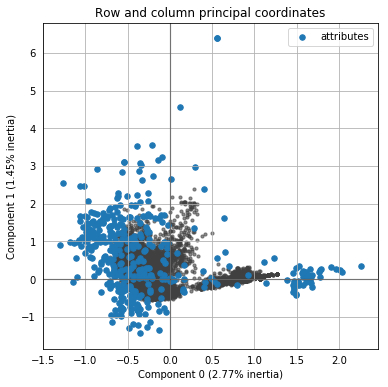

In [175]:
ax = mca.plot_coordinates(
     X=x_bus,
     ax=None,
     figsize=(6, 6),
     show_row_points=True,
     row_points_size=10,
     show_row_labels=False,
     show_column_points=True,
     column_points_size=30,
     show_column_labels=False,
     legend_n_cols=1
)

In [88]:
# # aggregate all non restaurant attributes, restaurant attributes
# # Resulting features: nonres_attributes, res_attributes
# att_features = [c for c in df_business.columns if c.startswith('attributes')][1:]  # 'drop 'attributes' since its first'
# nonres_feats = ['attributes_AcceptsInsurance', 'attributes_AgesAllowed','attributes_BikeParking', 'attributes_BusinessAcceptsBitcoin',
#        'attributes_BusinessAcceptsCreditCards', 'attributes_BusinessParking',
#        'attributes_ByAppointmentOnly', 'attributes_CoatCheck', 'attributes_DogsAllowed', 'attributes_HairSpecializesIn']
# res_feats = [a for a in att_features if a not in nonres_feats]

In [100]:
# x_bus = x_bus.fillna('Missing') 

In [93]:
# x_bus[nonres_feats] = x_bus[nonres_feats].fillna(0)
# for c in x_bus[nonres_feats].columns:
#     x_bus[c] = face

attributes_AcceptsInsurance 11888 12058
attributes_AgesAllowed 11992 12058
attributes_BikeParking 1462 12058
attributes_BusinessAcceptsBitcoin 10246 12058
attributes_BusinessAcceptsCreditCards 582 12058
attributes_BusinessParking 1283 12058
attributes_ByAppointmentOnly 10720 12058
attributes_CoatCheck 9924 12058
attributes_DogsAllowed 9324 12058
attributes_HairSpecializesIn 11978 12058


In the end, I'm not going to make a kNN. The preprocessing of that many categorical variables is tedious work and the sparsity resulting from one-hot encoding would only lower accuracy past baseline for sure. MCA clearly won't work. this looks like a case for RF

## User-Based KNN

yelping_since feature probably needs converting to a datetime. Let's look at the variance after normalizng of some of the variables and decide throw some out because of sparsity. Taking out name. yelping_since too for now

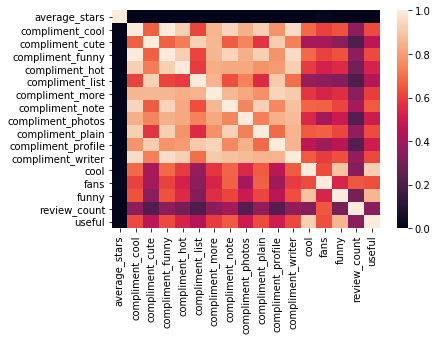

In [39]:
x_corr = user_data.drop('user_id',axis=1)
corr = user_data.corr()
sns.heatmap(corr)

as expected, anything that starts with compliment correlates with each other. cuz theres like tons of 0's in them. all the other columns don't correlate. And everything negatively correlates to average stars haha

### Small test with kNN

In [28]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error 
from math import sqrt

In [40]:
train, val = train_test_split(x_users.drop('user_id',axis=1), test_size=.2)

X_train = train.drop('average_stars', axis=1)
y_train = train['average_stars']

X_val = val.drop('average_stars',axis=1)
y_val = val['average_stars']

In [41]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

D:\Users\aznro\Anaconda3\envs\fastai\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Users\aznro\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
D:\Users\aznro\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  """


In [325]:
for K in range(1,8):
    regressor = KNeighborsRegressor(n_neighbors=K, weights='distance',metric='cosine')
    regressor.fit(X_train,y_train)
    pred = regressor.predict(X_val)
    error = sqrt(mean_squared_error(y_val,pred)) #calculate rmse
    print('RMSE error for {} neighbors: {}'.format(K,error))

RMSE error for 1 neighbors: 1.3843047801524158
RMSE error for 2 neighbors: 1.1914878232340298
RMSE error for 3 neighbors: 1.1663683695457672
RMSE error for 4 neighbors: 1.1228145574396524
RMSE error for 5 neighbors: 1.1093142817967814
RMSE error for 6 neighbors: 1.0858626622562806
RMSE error for 7 neighbors: 1.0830720151034303


## User-based KNN

Just for predicting average stars of similar users it works pretty well. This is only a test. When it comes to predicting business's ratings, the sparsity will become an issue so i won't prove it here. Now I make the actual model

#### kNN Helper Functions


In [387]:
def getNeighDict(neigh, X_train, X_test, n_neighbors=4):
    ''' Key: User_id 
        Value: K Nearest Neighbors in X_train for every user in X_test
        
        Careful! it uses the global df_users
    '''
    u_ids_trn = X_train.user_id   # X_train should have user_id and X_users doesn't
    X_users = X_train.drop('user_id',axis=1)
#     u_ids = X_train[['user_id']].user_id
    user_vals = X_users.values
    nhbrs_dict = dict()
    
    for u in tqdm(X_test.user_id.unique(), desc='NeighDict'):
        # Assume every user is in df_user
        # nhbrs gives back indices of the nearest neighbors of the vector user_id == u for X_users
        nhbrs = neigh.kneighbors([user_vals[u]], n_neighbors=n_neighbors, return_distance=False)[0]
        nhbrs_dict[u] = nhbrs
        # Using the indicies, get the user_id
#         nhbrs_dict[u] = u_ids.iloc[nhbrs[1:]].tolist()  #take out first since it'll always be the same user as input user
    return nhbrs_dict

def getBusAvgDict(X_test):
    ''' Gets the avg of all Business_Id in test set. just using the stars columns. Use for validation data.
        It geets all the averages frrom bus_data for all business appearing in val data.
    
        Careful! it uses global bus_data
    '''
    bus_avg = dict()
    # kNN_bus is just a dataframe with only business_id and stars
    kNN_bus_vals = bus_data['average_stars'].values
    b_test = X_test.business_id.unique()
    
    for b in tqdm(b_test, desc='BusAvgDict'):
        # Assume bus_data has every business
        bus_avg[b] = kNN_bus_vals[b]
    return bus_avg

def getUserAvgDict(X_test):
    '''Ditto business average but for users'''
    user_avg = dict()
    kNN_user_vals = user_data['average_stars'].values
    u_test = X_test.user_id.unique()
    
    for u in tqdm(u_test, desc='UserAvgDict'):
         user_avg[u] = kNN_user_vals[u]
    return user_avg

# key = user_id, value is list of all the businesses in train_reviews that user_id rated
def getUBDict():
    ''' Key: tuple of user_id, business_id seen in train_reviews
        Value: Rating user gave to that business
        
        Careful! Uses global trn_data
    '''
    ub_dict = dict()
    v = trn_data[['business_id','stars','user_id']].values
    for i in tqdm(range(len(trn_data)), desc='UBDict'):
        user = v[i,2]
        bus = v[i,0]
        star = v[i,1]
        if (user, bus) in ub_dict:
            raise Exception('same pair in train_data') 
        else:
            ub_dict[(int(user),int(bus))] = star
    return ub_dict

#### User-based kNN

In [20]:
ub = getUBDict()     # train_reviews turned into (u,b) : star

UBDict: 100%|█████████████████████████████████████████████████████████████| 150232/150232 [00:00<00:00, 1068122.68it/s]


In [92]:
# Make Nearest Neighbor model
# Don't forget Standard Scaler
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import RobustScaler
def kNN_Yelp(X_train, X_test, n_neighbors=4):
    neigh = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto', metric='cosine')
    X_users = X_train.drop('user_id',axis=1).astype(np.float64)
    u_ids = X_train[['user_id']]
    
#     scaler = StandardScaler()
#     scaler.fit(X_users)
#     X_users = scaler.transform(X_users)
    scaler = RobustScaler()
    scaler.fit(X_users)
    X_users = scaler.transform(X_users)
    neigh.fit(X_users)
    
    # average ratings for each business
    bd = getBusAvgDict(X_train)
    ud = getUserAvgDict(X_train)
    
    # get a dictionary; for every user in X_test find the closest k users. then get their ratings for the business b
    # if they didn't rate business b, then use the user business or user average
    nd = getNeighDict(neigh, X_train, X_test, n_neighbors=4)
    preds = []
    X_test_vals = X_test[['user_id','business_id']].values
    for i in tqdm(range(len(X_test)), desc='Preds'):
        u,b = X_test_vals[i,0], X_test_vals[i,1]  #user and business
        near_users = nd[u]
        total = 0
        for n in near_users:
            if (n,b) in ub:
                total += ub[(n,b)]
            else:
                total += ud[u]  # user user or business average
        preds.append(total/n_neighbors)
    return preds

cross validate for a good K

In [93]:
# just testing kNN
kNN_preds = kNN_Yelp(user_data, val_data, n_neighbors=4)
y_predicted = kNN_preds
y_actual = val_queries.stars.values
rmse_error = sqrt(mean_squared_error(y_actual, y_predicted))
rmse_error

Preds: 100%|█████████████████████████████████████████████████████████████████| 50077/50077 [00:00<00:00, 205783.18it/s]


1.1185436267815747

kNN so bad (probably cuz of sparsity) that taking standardscaler gives the same rmse. aigoo. kNN so bad this might as well be baseline hahaha

In [91]:
# just testing kNN
kNN_preds = kNN_Yelp(user_data, val_data, n_neighbors=4)
y_predicted = kNN_preds
y_actual = val_queries.stars.values
rmse_error = sqrt(mean_squared_error(y_actual, y_predicted))
rmse_error

Preds: 100%|█████████████████████████████████████████████████████████████████| 50077/50077 [00:00<00:00, 211859.73it/s]


1.11855594298306

In [29]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error 
from math import sqrt
# kNN_preds = kNN_Yelp(user_data, val_data)

n_folds = 5
cv_scores = []
best_kNN_preds = None
lowest_rmse_error = 999
for k in range(1,20):   
    # NOT CROSS VAL!!!!!!!!!!!!!!!!! 
    kNN_preds = kNN_Yelp(user_data, val_data, n_neighbors=k)
    y_predicted = [(g+h)/2 for g,h in zip(flat_preds,kNN_preds)]
    y_actual = val_queries.stars.values
    rmse_error = sqrt(mean_squared_error(y_actual, y_predicted))
    if rmse_error < lowest_rmse_error:
        lowest_rmse_error = rmse_error
        best_kNN_preds = kNN_preds
    cv_scores.append(rmse_error)

#     kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
#     scores = np.sqrt(-cross_val_score(kNN_Yelp, user_data, val_data, scoring="neg_mean_squared_error", cv = kf))
#     cv_scores.append(scores.mean())
print(cv_scores)

Preds: 100%|█████████████████████████████████████████████████████████████████| 50077/50077 [00:00<00:00, 269949.03it/s]
[5.9123030473132925, 2.2144396322067967, 1.3113316673029543, 1.1868909683534463, 1.2775618922001712, 1.3971255969228094, 1.5046777838562313, 1.5949557016214655, 1.6699231402057717, 1.7324934586073402, 1.7852201079990064, 1.8301202228611513, 1.8687452973282774, 1.9022856471640077, 1.9316603452684684, 1.9575859927236527, 1.9806274086064888, 2.0012346530256004, 2.0197701276774946]


#### Hybrid Collaborative filtering?

I just want to see if I can combine two collaborative filtering techniques. One is model-based which is the embeddingnet. the other is memory-based which is the kNN. 

I'll do it by simply weighting their like $\alpha*KNNpred + \beta*EmbeddingNetpred = pred$, for each user. There are many entries with the same user in val_queries. $\alpha$ + $\beta$ = 1, where alpha is (the amount kNN_pred is better than EmbeddingNetpred)/ total_pred; and same with beta. 

Then when eval the final queries, we first find the predictions for each entry, and then weight according to user_id. 

In [81]:
kNN_preds = kNN_Yelp(user_data, trn_data[['user_id','business_id']], n_neighbors=4)

Preds: 100%|███████████████████████████████████████████████████████████████| 150232/150232 [00:00<00:00, 254879.49it/s]


In [82]:
# CFHybrid weighting matrix
def getCFWeightMatrix():
    # key: user_id, value: [a b], where a is how many kNN is better and b is how many embedding better for that user
    d = dict()
    
    def addToDict(d, u, i):
        ''' d is the dictionary to add to
            u is user_id
            i is 0 or 1. 0 meaning kNN and 1 meaning embeddnet
        '''
        if u in d:
            if i == 0: d[u][0] += 1
            else:      d[u][1] += 1
        else:
            if i == 0: d[u] = [1, 0]
            else:      d[u] = [0, 1]
        return d
    
    def change2Probabilities(d):
        '''assuming d is done. now we just calculate probabilities for each list instead of counts'''
        d_new = dict()
        for k,v in d.items():
            total = sum(v)
            d_new[k] = list(map(lambda x: x/total,v))
        return d_new
    
    # make trn_data only have user_id, business_id
#     kNN_preds = kNN_Yelp(user_data, trn_data[['user_id','business_id']], n_neighbors=4)
    correct = trn_data['stars']
    users = trn_data['user_id']
    for i in range(len(flat_preds)):
        # if kNN did better for that user
        if abs(kNN_preds[i] - correct[i]) > abs(flat_preds[i] - correct[i]):
            addToDict(d, users[i], 0)
        else:
            addToDict(d, users[i], 1)
    
    return change2Probabilities(d)

In [83]:
def evaluation():
    last_predictions = []
    d = getCFWeightMatrix()
    eval_val = val_queries.drop('Unnamed: 0',axis=1)
#     kNN_preds = kNN_Yelp(user_data, val_data, n_neighbors=4)
    users = eval_val.user_id
    for i in range(len(eval_val)):
        u = users[i]
        alpha, beta = .5, .5
        if u in d:
            alpha = d[u][0]
            beta = d[u][1]
        last_predictions.append(alpha * kNN_preds[i] + beta * flat_preds[i])
    return last_predictions

In [84]:
y_predicted = evaluation()
y_actual = val_queries.stars.values
rmse_error = sqrt(mean_squared_error(y_actual, y_predicted))
rmse_error

1.28737386963196

## Tuning

In [230]:
from sklearn.metrics import mean_squared_error
from math import sqrt
# probably shouldn't be using lists as preds
y_predicted = kNN_preds
y_actual = val_queries.stars.values
rmse_error = sqrt(mean_squared_error(y_actual, y_predicted))
rmse_error 

1.1763020966576545

In [233]:
from sklearn.metrics import mean_squared_error
from math import sqrt
# probably shouldn't be using lists as preds

y_predicted = [(g+h)/2 for g,h in zip(flat_preds,kNN_preds)]
y_actual = val_queries.stars.values
rmse_error = sqrt(mean_squared_error(y_actual, y_predicted))
rmse_error 

1.1868909683534463

User based collaborative filtering isn't bad. 1.12is a pretty good score from 500 samples. Training took forever. Of course sparsity is still an issue. after running entire training set, KNN gave 1.5 error which is really bad. 

## Random Forest, XGBoost

With the sparsity issue, I think RF and XGBoost are promising

In [396]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [ ]:
# an use RF Regressor for feature selection
# X_train:  would just be x_users
# y_train: ???
# X_val = the users profile in df_users
# y_va; = val_queries.stars

# Content Based-Filtering
Content-based filtering approaches leverage description or attributes from items the user has interacted to recommend similar items. It depends only on the user previous choices, making this method robust to avoid the *cold-start* problem.
For textual items, like articles, news and books, it is simple to use the raw text to build item profiles and user profiles.  

## BDTR

### Missing

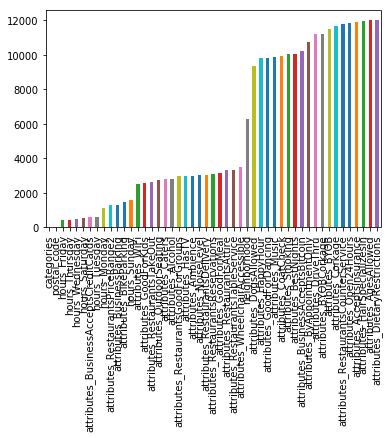

In [102]:
bus_missing= bus_bdtr.isnull().sum()
bus_missing = bus_missing[bus_missing > 0]
bus_missing.sort_values(inplace=True)
bus_missing.plot.bar()

In [212]:
user_missing = user_bdtr.isnull().sum()
user_missing
# user_missing = user_missing[user_missing > 0]
# user_missing.sort_values(inplace=True)
# user_missing.plot.bar()

average_stars         0
compliment_cool       0
compliment_cute       0
compliment_funny      0
compliment_hot        0
compliment_list       0
compliment_more       0
compliment_note       0
compliment_photos     0
compliment_plain      0
compliment_profile    0
compliment_writer     0
cool                  0
fans                  0
funny                 0
review_count          0
useful                0
dtype: int64

lots of features starting with attributes missing values. user data not missing anything

#### Imputation with clearly out of bounds values

### Kmeans
Clustering the businesses into categories

In [424]:
# bad features: all the ones that start with 'attirbutes'. I need to fillna(-1, inplace=True). use a value not in range
# iffy features that I can try adding later: neighborhood, name, city, categories
bus_bdtr = df_business[['latitude', 'longitude','review_count', 'average_stars']].copy()
# bus_bdtr['business_id'] = bus_bdtr['business_id'].apply(lambda x: business2idx[x])

In [421]:
bus_bdtr.head()

,latitude,longitude,review_count,stars
0,43.664125,-79.411886,146,4.0
1,33.479807,-112.091188,277,4.0
2,43.149488,-89.206641,102,4.5
3,36.201990,-115.283122,242,4.0
4,33.639774,-112.087738,230,3.5


#### Agglomerative Hiearchial Clustering: Instead of Kmeans
usually produces better k more more expensive. 

In [139]:
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

In [ ]:
# # create dendrogram
# dendrogram = sch.dendrogram(sch.linkage(bus_bdtr, method='ward'))
# # create clusters
# hc = AgglomerativeClustering(n_clusters=4, affinity = 'euclidean', linkage = 'ward')
# # save clusters for chart
# y_hc = hc.fit_predict(bus_bdtr)

#### Actual kmeans on df_business

In [ ]:
# determine how many clusters there should be using silhouette_score
# from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_score

# range_n_clusters = [2, 3, 4]            # clusters range you want to select
# dataToFit = [[12,23],[112,46],[45,23]]  # sample data
# best_clusters = 0                       # best cluster number which you will get
# previous_silh_avg = 0.0

# for n_clusters in range_n_clusters:
#     clusterer = KMeans(n_clusters=n_clusters)
#     cluster_labels = clusterer.fit_predict(dataToFit)
#     silhouette_avg = silhouette_score(dataToFit, cluster_labels)
#     if silhouette_avg > previous_silh_avg:
#         previous_silh_avg = silhouette_avg
#         best_clusters = n_clusters

# # Final Kmeans for best_clusters
# kmeans = KMeans(n_clusters=best_clusters, random_state=0).fit(dataToFit)

In [426]:
from sklearn.cluster import KMeans

# test multiple n_clusters
# # for i in range(4,10): 
kmeans = KMeans(n_clusters=5)
bus_bdtr['category'] = kmeans.fit_predict(bus_bdtr)

### BDTR Model

In [440]:
bus_bdtr = bus_bdtr[['latitude', 'longitude', 'review_count', 'average_stars', 'category']]
user_bdtr = user_data[['average_stars', 'fans', 'review_count']]

In [441]:
def makeBDTRMatrix(input_data):
    ''' Format is: User features|Business features|Rating
    '''       
    def getAvgCatStars(ub, cats, X):
        ''' This is the content-filtering part as ur making the connection between user and business

            Input:  ub is trn_data but in dictionary form, cat is categories that each business_id (the index) belongs to
            Output: Average user review of every business_id. If a business isn't in trn_data use user average
        '''            
        # key is category, value is just a list of list of stars
        # belonging to each category. each star represents the rating one user gave it in reviews
        cat_dict = dict()
        num_categories = cats.max()+1
        
        # For all users, crate a list of lists. user_id is just the index
        for u in range(len(user_bdtr)):
            cat_dict[u] = [[] for _ in range(num_categories)]
        
        # For training set, add the rating into the user category matrix
        for (u, b), s in ub.items():
            c = cats[b]    # c is the category that business b belongs to
            cat_dict[u][c].append(s)

        # now find average for each category for each user
#         ud = getUserAvgDict(X)   # gets the average of each user in X

        for u, v in cat_dict.items():
            for c in range(num_categories):
                # if the user has never done anything in this category, leave the []
                if cat_dict[u][c] != []:
                    cat_dict[u][c] = np.mean(cat_dict[u][c])
        return cat_dict
    data_ = input_data[['business_id','user_id','stars']].copy()
    d = data_.values
    res = pd.DataFrame()
    ub = getUBDict()
    ud = getUserAvgDict(input_data)
    cats = bus_bdtr['category'].values
    avg_cats = getAvgCatStars(ub, cats, trn_data[['user_id','business_id']])
    # Make column for the average user rating for each category
    avg_col = []
    for v in d:
        u = int(v[1])
        b = int(v[0])
        c = cats[b]
        if avg_cats[u][c] == []:
            avg_col.append(ud[u])
        else:
            avg_col.append(avg_cats[u][c])
    res['UserAvg4Category'] = avg_col
    # Replace business and user Id's with their corresponding features 
    bus_features = pd.DataFrame(columns=bus_bdtr.columns) 
    user_features = pd.DataFrame(columns=user_bdtr.columns)
    u_vals = user_bdtr.values
    b_vals = bus_bdtr.values
    
    for v in tqdm(d, desc='Final Matrix'): # [b, u , s]
        # user id's are in order for user_data so no need for user_id column since its just the index
        u = int(v[1])
        b = int(v[0])
        user_features = user_features.append(pd.Series(u_vals[u], index=user_features.columns),ignore_index=True)
        bus_features = bus_features.append(pd.Series(b_vals[b], index=bus_features.columns), ignore_index=True)
    # first join user_bdtr and bus_bdtrface
#     print('Missing Values in Users\n')
#     print(user_features.isnull().sum(axis=1))
    
    res = pd.concat([user_features, res, bus_features], axis=1, sort=False)
    return res

In [442]:
from sklearn.tree import DecisionTreeRegressor

def BDTR(X_train, y_train, X_test):
    '''Gives the predictions of BDTR model'''
    regressor = DecisionTreeRegressor()
    regressor.fit(X_train, y_train)
    return regressor.predict(X_test)

### BDTR Preds

In [443]:
trn_bdtr = makeBDTRMatrix(trn_data)
trn_bdtr.head()

UserAvgDict: 100%|██████████████████████████████████████████████████████████| 16556/16556 [00:00<00:00, 2069958.48it/s]


D:\Users\aznro\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:46: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


Final Matrix: 100%|███████████████████████████████████████████████████████████| 150232/150232 [08:47<00:00, 285.04it/s]


,average_stars,fans,review_count,UserAvg4Category,latitude,longitude,review_count,average_stars,category
0,4.50,0.0,4.0,4.500000,43.072715,-89.384413,128.0,4.0,1.0
1,3.96,238.0,2100.0,4.500000,33.479016,-112.047963,1344.0,4.0,4.0
2,3.96,238.0,2100.0,4.333333,36.104614,-115.176021,2666.0,2.5,3.0
3,3.96,238.0,2100.0,3.600000,36.098268,-115.167405,173.0,3.5,1.0
4,3.96,238.0,2100.0,4.625000,36.104613,-115.174527,311.0,4.5,0.0


In [444]:
X_test = val_data.copy()
X_test['stars'] = val_queries.stars
val_bdtr = makeBDTRMatrix(X_test)
val_bdtr.head()

UserAvgDict: 100%|██████████████████████████████████████████████████████████| 14145/14145 [00:00<00:00, 2026036.61it/s]


D:\Users\aznro\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:46: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


Final Matrix: 100%|█████████████████████████████████████████████████████████████| 50077/50077 [01:17<00:00, 647.69it/s]


,average_stars,fans,review_count,UserAvg4Category,latitude,longitude,review_count,average_stars,category
0,2.63,0.0,6.0,2.63,36.158475,-115.126550,1492.0,4.0,4.0
1,3.78,20.0,654.0,4.00,43.649994,-79.383952,208.0,4.0,1.0
2,3.48,8.0,120.0,4.00,36.110195,-115.173698,854.0,4.0,4.0
3,3.47,11.0,49.0,3.47,43.803192,-79.419510,396.0,4.5,0.0
4,4.13,0.0,38.0,4.13,36.127429,-115.224072,1317.0,4.0,4.0


In [445]:
y_bdtr = trn_data['stars']

preds_bdtr = BDTR(trn_bdtr, y_bdtr, val_bdtr)

In [446]:
assert(len(val_queries) == len(preds_bdtr))
y_predicted = preds_bdtr
y_actual = val_queries.stars.values
rmse_error = sqrt(mean_squared_error(y_actual, y_predicted))
rmse_error

1.4822067053738217

# Hybrid 

## BDTR + KNN

In [439]:
import math
# I'm just going to multiply the scores and then run it into a sigmoid*range
def sigmoid(x):
    return 1 / (1 + math.exp(-x))
hybrid_preds = []
for a,b in zip(preds_bdtr, kNN_preds):
    hybrid_preds.append(sigmoid(a*b) * 5)
    
y_predicted = hybrid_preds
y_actual = val_queries.stars.values
rmse_error = sqrt(mean_squared_error(y_actual, y_predicted))
rmse_error

1.654273714322605

# TODO:
- Skorch Cross validation and Hyperparameter tuning + adding SGDR, adamW 
- use confusion matrix, plot graphs...
- Cross val K for KNN
- Try:
    - Have to throw out users that have review_counts lower than certain number for item-item similarity model
    - Have to do the same for businesses

